# Exercise project 3 (CNN time-series classification)
### **Step 0:** Importing necessary libraries

In [84]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

### **Step 1**: Reading the dataset

In [85]:
df = pd.read_csv("BTC-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


Let's check if the dataset has any null values and use describe to have an overview of the numerical columns.

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2691 entries, 0 to 2690
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2691 non-null   object 
 1   Open       2691 non-null   float64
 2   High       2691 non-null   float64
 3   Low        2691 non-null   float64
 4   Close      2691 non-null   float64
 5   Adj Close  2691 non-null   float64
 6   Volume     2691 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 147.3+ KB


In [87]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2.691000e+03
mean,11067.257301,11365.906054,10735.769010,11078.838895,11078.838895,1.464449e+10
std,15942.260540,16372.505178,15442.789057,15944.078311,15944.078311,2.008151e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,603.274506,607.488006,598.279511,605.210510,605.210510,7.854280e+07
50%,6253.549805,6388.629883,6119.680176,6274.580078,6274.580078,5.014430e+09
75%,10346.236817,10572.645996,10111.598144,10347.236817,10347.236817,2.457629e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


### **Step 2:** Data cleanup, sequencing and scaling

For this excercise, I will use the *Close* and *Volume* columns as the 2 classes.

In [88]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)

I scale the numeric columns using *scikit-learn*'s *MinMaxScaler()*

In [89]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

num_cols = ['Close', 'Volume']
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,Date,Close,Volume
0,2014-09-17,0.004144,0.000043
1,2014-09-18,0.003655,0.000081
2,2014-09-19,0.003216,0.000091
3,2014-09-20,0.003425,0.000088
4,2014-09-21,0.003275,0.000059


The Date column should be converted to a sequence column, so that the model can understand it.

In [90]:
df['Sequence'] = df.index + 1
df = df.drop(['Date'], axis=1)
df.head()

,Close,Volume,Sequence
0,0.004144,0.000043,1
1,0.003655,0.000081,2
2,0.003216,0.000091,3
3,0.003425,0.000088,4
4,0.003275,0.000059,5


### **Step 3:** Timesteps
I create sliding windows, then to make a timestep with a size of 50, I chose every 50th window. Then I combine the windows to a vstack named *X* and create the *y* target value array, with 0 indicating the *Close* values and 1 the *Volume* values.

In [91]:
from numpy.lib.stride_tricks import sliding_window_view

timestep_size = 50

close = df['Close'].values
volume = df['Volume'].values

close_windows = sliding_window_view(close, window_shape=timestep_size)[::timestep_size]
volume_windows = sliding_window_view(volume, window_shape=timestep_size)[::timestep_size]

X = np.vstack((close_windows, volume_windows))

# 0 = Close
# 1 = Volume
y = np.array([0] * len(close_windows) + [1] * len(volume_windows))

print("X:", X.shape)
print("y:", y.shape)

X: (106, 50)
y: (106,)


Then, I shuffle the data to see if we get better results and less overfitting.

In [92]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

The train/test split will be at the 75% mark. Every record before that is the training data and every record after that is the testing data.

In [93]:
train_size = 0.75
splitter = int(len(X) * train_size)

x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

In [94]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

79
27
79
27


Now the data will be converted to a CNN-compatible format. I print it out to see if it's similar to the example we had on the lecture.

In [95]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_train

array([[[2.62269131e-01],
        [3.02302158e-01],
        [1.81471504e-01],
        ...,
        [1.65922668e-01],
        [1.31849985e-01],
        [1.47659205e-01]],

       [[2.97011121e-03],
        [2.82931604e-03],
        [2.89296173e-03],
        ...,
        [3.59879200e-03],
        [3.43447671e-03],
        [3.44777264e-03]],

       [[1.22416613e-03],
        [1.14839696e-03],
        [1.11408839e-03],
        ...,
        [9.23670983e-04],
        [9.01768017e-04],
        [9.32648687e-04]],

       ...,

       [[2.42457284e-05],
        [2.99474849e-05],
        [3.68200233e-05],
        ...,
        [1.00282445e-04],
        [1.43862943e-04],
        [1.59958416e-04]],

       [[9.39702508e-01],
        [9.33859369e-01],
        [9.36891277e-01],
        ...,
        [5.26794740e-01],
        [5.51349686e-01],
        [5.41734878e-01]],

       [[4.88721825e-02],
        [5.33242701e-02],
        [4.86551958e-02],
        ...,
        [8.92064239e-02],
        [1.0361

### **Step 5:** Creating the CNN model
The model uses keras layers with a convolutional layer, pooling and flattening, and a Dense output layer.

In [96]:
class_names = np.array(['Close', 'Volume'])
num_classes = len(class_names)
classes = [0, 1]
input_shape=x_train.shape[1:]

model = keras.Sequential(
    [
        keras.layers.Input(input_shape),

        keras.layers.Conv1D(filters=18, kernel_size=3, padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),

        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Flatten(),

        keras.layers.Dense(14, activation="relu"),

        keras.layers.Dense(num_classes, activation="softmax")
    ]
)

#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 50, 18)         │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 18)         │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 50, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 18)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 14)             │           266 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 440 (1.72 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 36 (144.00 B)

### **Step 6:** Compiling model and fitting data
I compile the model and fit the now CNN-compatible data to the model.

In [97]:
epochs = 380
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    )
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/380
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - loss: 0.7929 - sparse_categorical_accuracy: 0.3651 - val_loss: 0.7068 - val_sparse_categorical_accuracy: 0.3125
Epoch 2/380
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.7769 - sparse_categorical_accuracy: 0.3810 - val_loss: 0.7065 - val_sparse_categorical_accuracy: 0.2500
Epoch 3/380
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.7685 - sparse_categorical_accuracy: 0.3810 - val_loss: 0.7062 - val_sparse_categorical_accuracy: 0.1875
Epoch 4/380
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.7490 - sparse_categorical_accuracy: 0.3651 - val_loss: 0.7059 - val_sparse_categorical_accuracy: 0.1250
Epoch 5/380
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.7450 - sparse_categorical_accuracy: 0.3810 - val_loss: 0.7057 - val_sparse_categorical_accuracy: 0.1250
Epoch 6/380
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.7340 - sparse_categorical_accuracy: 0.3968 - val_loss: 0.7055 - val_sparse_categorical_accuracy: 0.1250
Epoch 7/38

#### **Training loss:**

<Axes: >

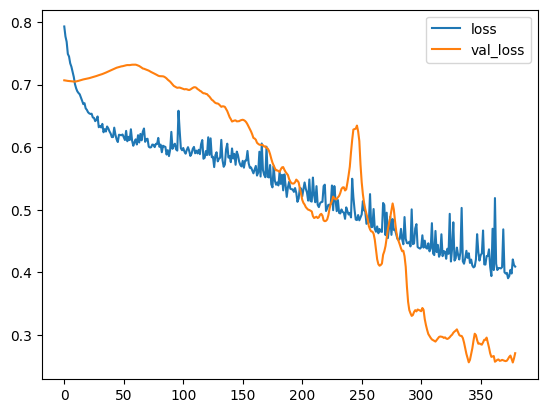

In [98]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

#### **Training accuracy:**

<Axes: >

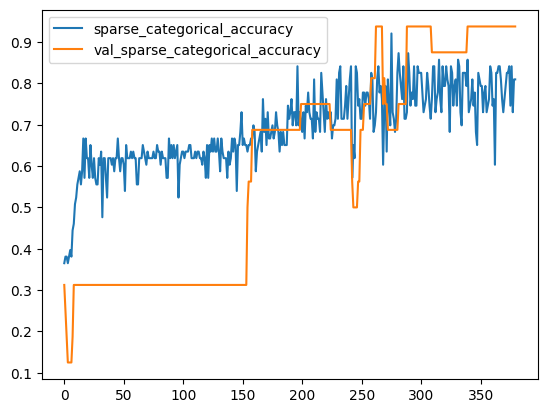

In [99]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

#### **Train and test data evaluation:**

In [100]:
model = keras.models.load_model("best_model2.keras")

print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[0.6311264038085938, 0.7407407164573669]

Train data evaluation:
[0.7415599822998047, 0.6962025165557861]


### **Step 7:** Prediction and metrics
In this step, I predict the values with the model, and see how the accurate the model is.

In [101]:
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


#### **Confusion matrix:**

<Axes: >

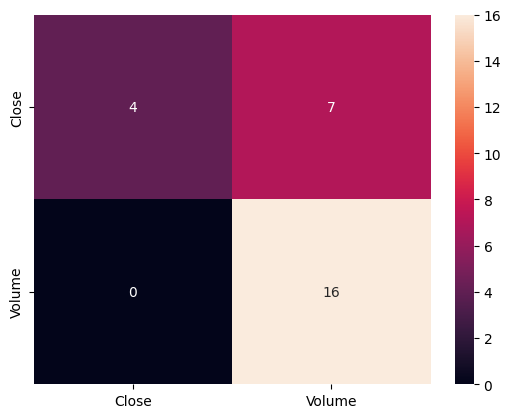

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, test_predictions)
ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

#### **Classification report and overall accuracy:**

In [103]:
print(classification_report(y_test, test_predictions, target_names=class_names))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

       Close       1.00      0.36      0.53        11
      Volume       0.70      1.00      0.82        16

    accuracy                           0.74        27
   macro avg       0.85      0.68      0.68        27
weighted avg       0.82      0.74      0.70        27


Model overall accuracy: 74.07%


In [104]:
# reshape X to include the channel dimension expected by the model
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))

# ensure y is a 1d array of labels (not one-hot)
y_true = y
if hasattr(y_true, "ndim") and y_true.ndim > 1:
	y_true = np.argmax(y_true, axis=1)

# predict class probabilities
probs = model.predict(X_reshaped)

# compute ROC AUC; handle binary/multiclass score shapes
try:
	roc = roc_auc_score(y_true, probs, multi_class="ovr")
except ValueError:
	# fallback for binary: use probability of the positive class
	roc = roc_auc_score(y_true, probs[:, 1])
print("ROC AUC (ovr):", roc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
ROC AUC (ovr): 0.7796368814524741


In [105]:
#Print out the exact probabilities for each class when trying some data. 

Step 8:

In [106]:
#Generative AI code